In [1]:
!pip install minisom matplotlib

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.2-py3-none-any.whl size=10650 sha256=d6852103844f8d6e9441d874b497d8a6b999d498e6ce53e93cae70b1127acbbc
  Stored in directory: /root/.cache/pip/wheels/b4/f6/8a/9daf8831901c3e3805775633404248f10663d1c80b7e5a1314
Successfully built minisom


In [2]:
from IPython import display

import numpy as np
from minisom import MiniSom
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

# Download MNIST dataset
X_mnist, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
# Normalize data
X_mnist = X_mnist / 255.0



/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X_mnist = X_mnist[y == '1']
X_mnist.shape

(7877, 784)

# miniSOM

In [4]:
def plot_som_centroids(som, som_size):
    # Plot the weights of the Kohonen map
    plt.figure(figsize=(som_size, som_size))
    for i in range(som_size):
        for j in range(som_size):
            weight = som.get_weights()[i, j].reshape(28, 28)  # Reshape weights to 28x28 (MNIST images size)
            plt.subplot(som_size, som_size, i*som_size+j+1)
            plt.imshow(weight, cmap='gray')
            plt.axis('off')
    plt.show()

In [5]:
# Initialize Kohonen map (SOM)
som_size = 20  # 10x10 grid
som = MiniSom(som_size, som_size, X_mnist.shape[1], sigma=1.0, learning_rate=0.5)

# Train SOM

In [7]:
print("Training Kohonen map...")

for epoch in range(10):
    print(f"Epoch {epoch+1}/10, Quantization error:, {som.quantization_error(X_mnist)}", end=" ")

    som.train_random(X_mnist, X_mnist.shape[0])  # Train with 60000 iterations
    print()

print("Training completed.")

Training Kohonen map...
Epoch 1/10, Quantization error:, 7.048757723691917 
Epoch 2/10, Quantization error:, 2.1748989527738 
Epoch 3/10, Quantization error:, 2.0590420336679074 
Epoch 4/10, Quantization error:, 1.9876188680058184 
Epoch 5/10, Quantization error:, 1.9637910873865139 
Epoch 6/10, Quantization error:, 1.9413958271898069 
Epoch 7/10, Quantization error:, 1.9379472818000625 
Epoch 8/10, Quantization error:, 1.9365220725550332 
Epoch 9/10, Quantization error:, 1.934053816871436 
Epoch 10/10, Quantization error:, 1.9354144749124251 
Training completed.


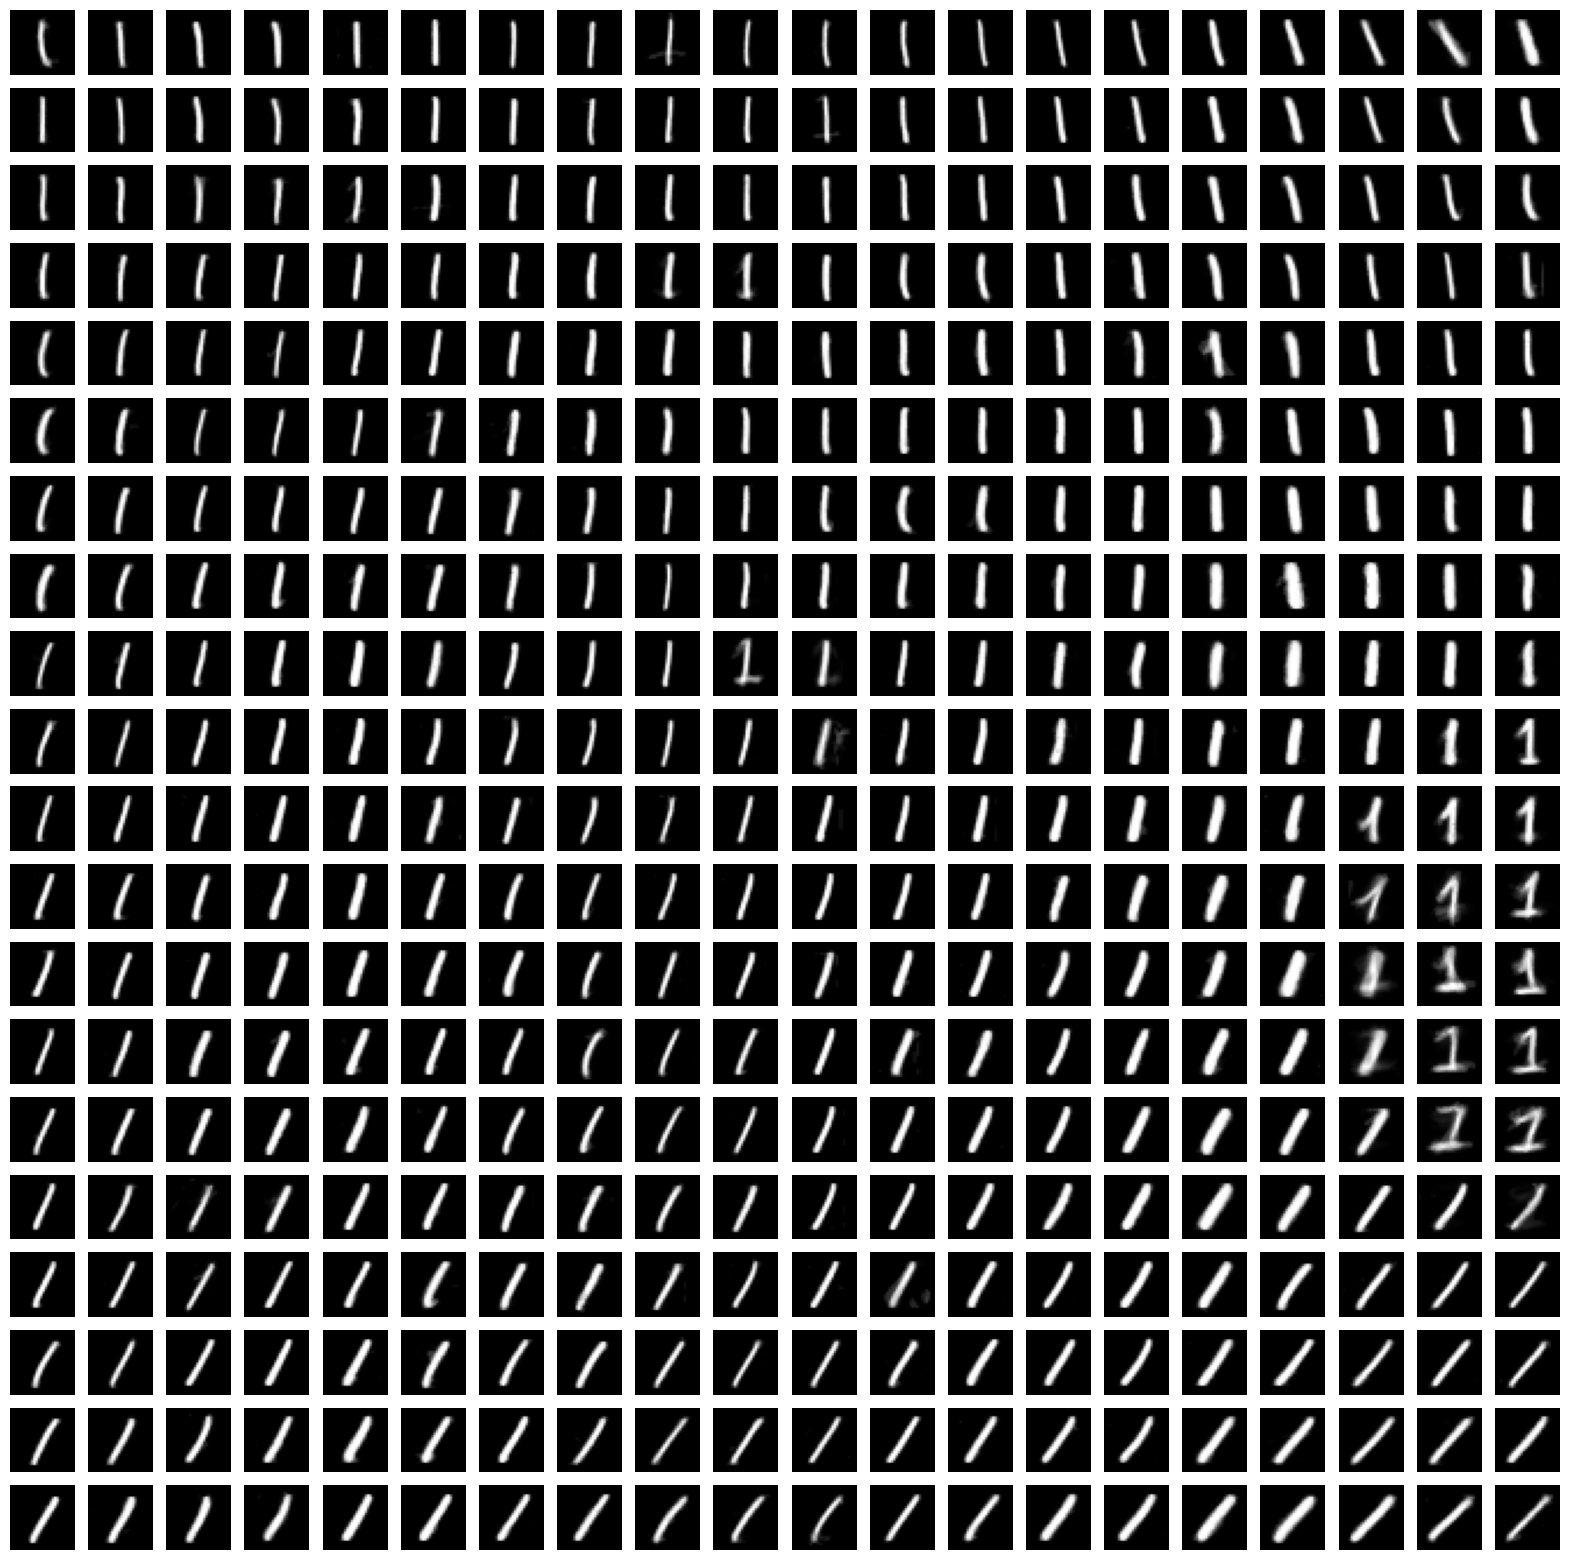

In [8]:
plot_som_centroids(som, som_size)


# learning inverse function

In [9]:
from sklearn.neighbors import NearestNeighbors

def round_centroids(som, som_size, X_mnist):
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(X_mnist)

    round_centroids = np.zeros((som_size, som_size, 28, 28))
    for i in range(som_size):
        for j in range(som_size):
            centroid = som.get_weights()[i, j].reshape(1, -1)
            _, idx = nn.kneighbors(centroid, 1)

            round_centroids[i,j] = X_mnist[idx,:].reshape(28,28)
    return round_centroids

rounded_centroids = round_centroids(som, som_size, X_mnist)

Poniżej: $X \in \mathbb{R}^2$, natomiast $Y\in \mathbb{R}^{784}$. $x_i$ to pozycja $i$-tego centroidu w topologii mapy Kohonena, natomiast $y_i$ to nie jest sama surowa pozycja tego centroidu w $\mathbb{R}^{784}$, tylko $y_i$ to jest najbliższy centroidowi prawdziwy obrazek. Dzięki temu model uczy się na obrazkach z ostrzejszym detalem.

In [10]:
X = np.zeros((som_size**2, 2))
Y = np.zeros((som_size**2, 784))

for i in range(som_size):
    for j in range(som_size):
        X[i*som_size+j,:] = np.array([i, j])
        Y[i*som_size+j,:] = rounded_centroids[i,j].reshape(1, -1)

In [11]:
!pip install xgboost

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor

model = make_pipeline(PolynomialFeatures(2), XGBRegressor())
model.fit(X, Y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [ ]:
X

array([[ 0.,  0.],
       [ 0.,  1.],
       [ 0.,  2.],
       [ 0.,  3.],
       [ 0.,  4.],
       [ 0.,  5.],
       [ 0.,  6.],
       [ 0.,  7.],
       [ 0.,  8.],
       [ 0.,  9.],
       [ 0., 10.],
       [ 0., 11.],
       [ 0., 12.],
       [ 0., 13.],
       [ 0., 14.],
       [ 0., 15.],
       [ 0., 16.],
       [ 0., 17.],
       [ 0., 18.],
       [ 0., 19.],
       [ 1.,  0.],
       [ 1.,  1.],
       [ 1.,  2.],
       [ 1.,  3.],
       [ 1.,  4.],
       [ 1.,  5.],
       [ 1.,  6.],
       [ 1.,  7.],
       [ 1.,  8.],
       [ 1.,  9.],
       [ 1., 10.],
       [ 1., 11.],
       [ 1., 12.],
       [ 1., 13.],
       [ 1., 14.],
       [ 1., 15.],
       [ 1., 16.],
       [ 1., 17.],
       [ 1., 18.],
       [ 1., 19.],
       [ 2.,  0.],
       [ 2.,  1.],
       [ 2.,  2.],
       [ 2.,  3.],
       [ 2.,  4.],
       [ 2.,  5.],
       [ 2.,  6.],
       [ 2.,  7.],
       [ 2.,  8.],
       [ 2.,  9.],
       [ 2., 10.],
       [ 2., 11.],
       [ 2.,

In [13]:
def plot_generation(model, rounded_centroids):
    som_size = rounded_centroids.shape[0]
    plt.figure(figsize=(som_size, som_size))
    for i in range(som_size):
        for j in range(som_size):
            x = np.array([[i, j]]) + np.random.uniform(low=-0.5, high=0.5, size=(2))
            plt.subplot(som_size, som_size, i*som_size+j+1)
            plt.imshow(model.predict(x).reshape(28,28), cmap='gray')
            plt.axis('off')
    plt.show()

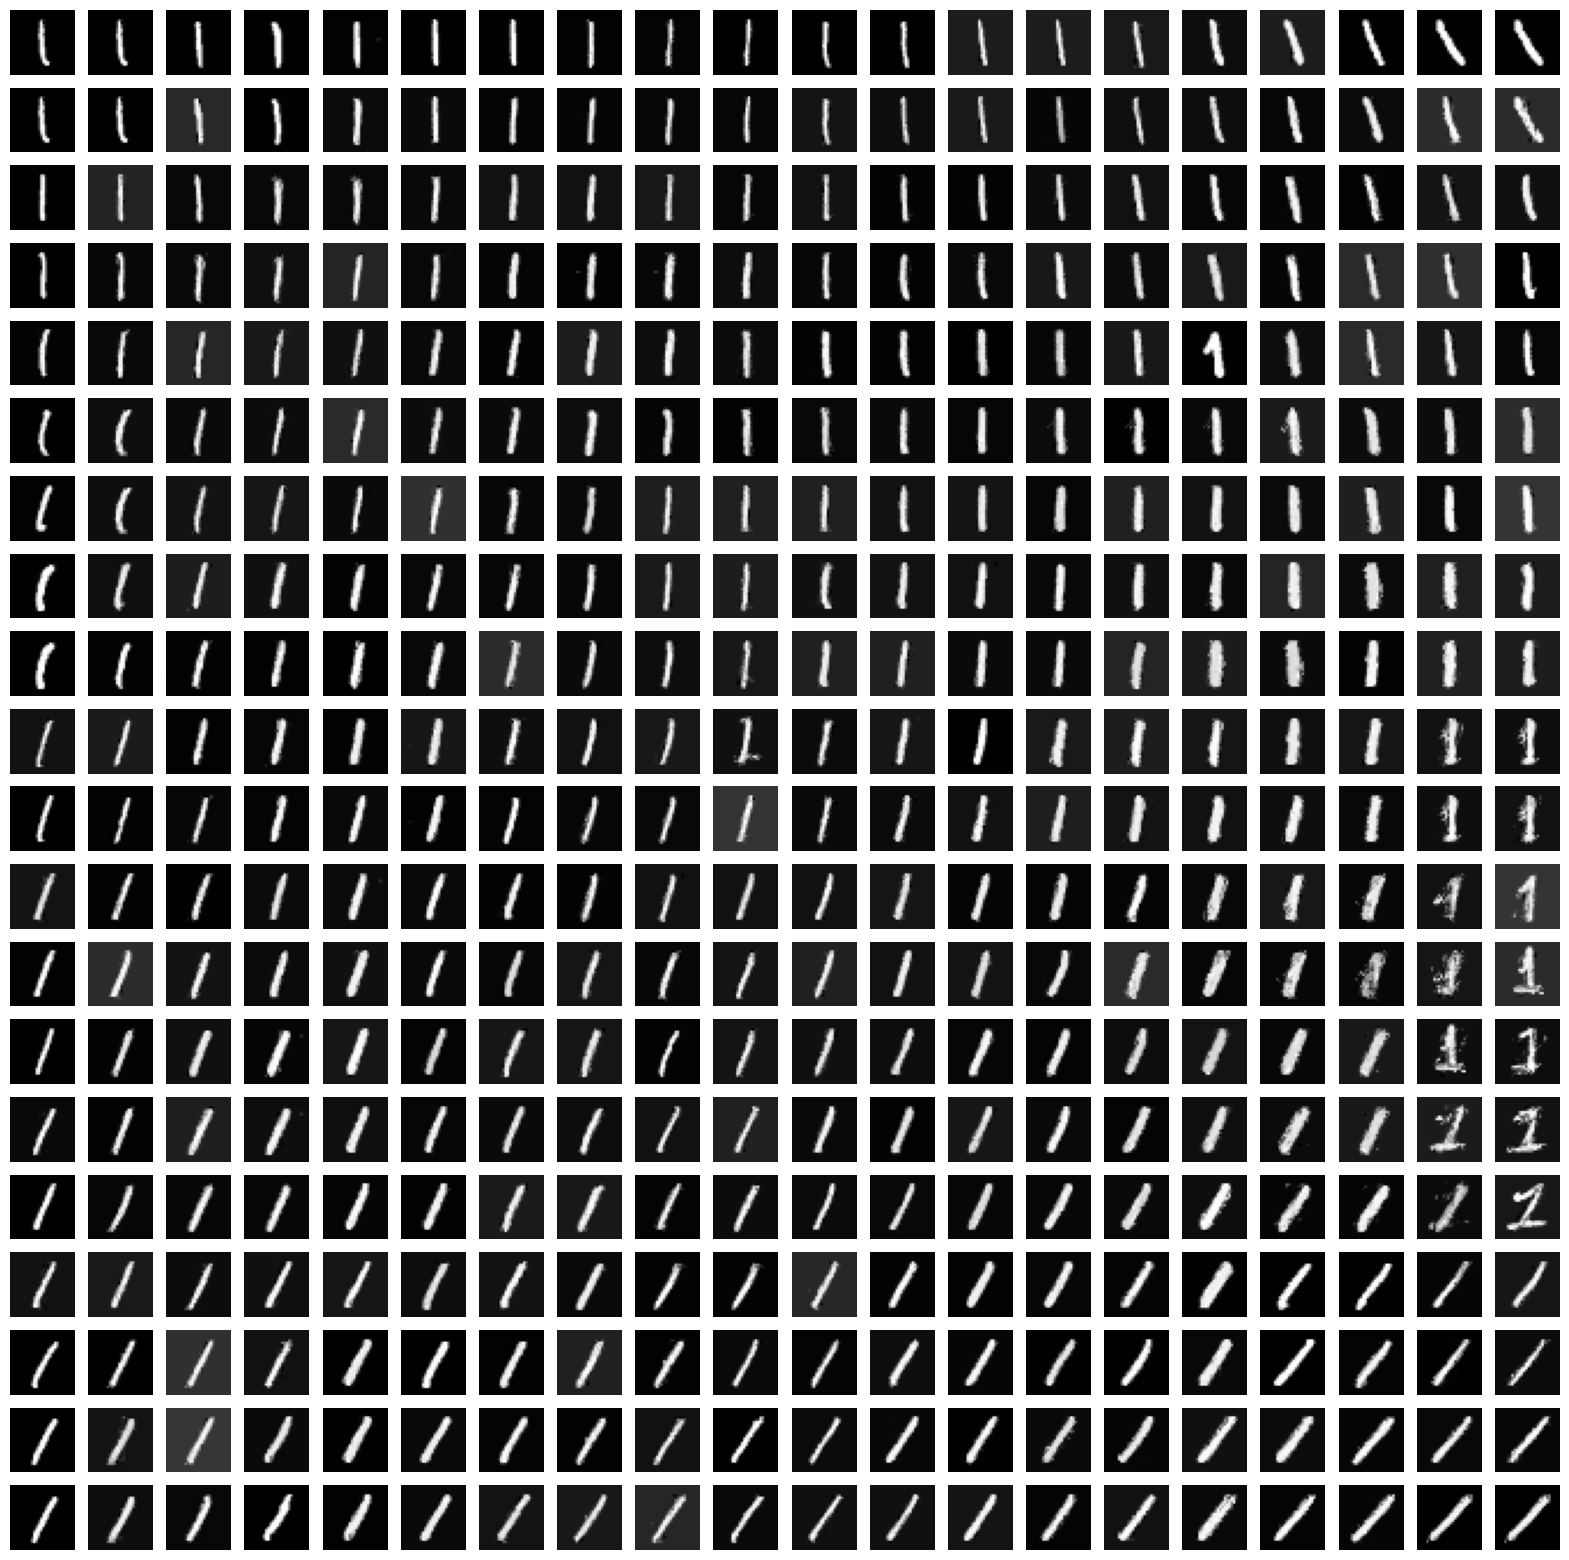

In [14]:
plot_generation(model, rounded_centroids)

# jak ocenić jakość generacji?

Użyjmy kolejnego klasyfikatora do oceny jakości generowania. Stwórzmy dataset złożony z oryginalnych obrazków i złożony z takiej samej ilości obrazków wygenerowanych przez nas. Labele y mówią 1, gdy prawdziwy, a 0, gdy fejk.
Intuicja:
- jeśli obrazki są słabe, to k-NN będzie miał 100% accuracy przy klasyfikacji
- jeśli obrazki są idealnie wierne oryginałom, to accuracy będzie bardzo niskie

Zadanie do pomyślenia:
- **czy w ogóle możliwe jest, aby 1-NN klasyfikator mógł mieć kiedykolwiek 0% accuracy? co dla 2-NN?**

In [15]:
X_tru = Y
X_tru.shape

(400, 784)

In [16]:
data_uniform = np.random.uniform(0, 19, (X_tru.shape[0], 2))
data_uniform

array([[ 3.4929234 , 11.97755807],
       [ 1.68920409,  2.63123429],
       [13.7277408 , 18.95327561],
       [10.69100982, 15.467447  ],
       [18.52008372, 15.80774734],
       [11.68678024, 14.29257455],
       [18.44422424,  5.27630753],
       [16.68597636, 13.69182154],
       [12.35178309,  6.86234168],
       [ 2.59089391, 14.59467364],
       [10.71909973, 16.64785642],
       [13.37409691,  2.32814709],
       [ 1.30820764, 11.64254668],
       [ 8.2912827 , 17.47580745],
       [ 0.21894248,  3.79149234],
       [13.52846521,  5.58055776],
       [ 1.7118618 , 18.40237408],
       [ 1.27701406,  7.42044715],
       [ 1.62760446, 13.50233602],
       [10.35446093, 15.50734697],
       [14.8787659 ,  6.1156691 ],
       [16.93435795, 11.44054687],
       [16.89794726,  0.85316273],
       [ 9.34925805, 13.97122149],
       [ 7.9687558 , 15.48121941],
       [15.91345679, 16.10179905],
       [15.5632207 , 18.75744126],
       [ 8.8892272 , 15.1833252 ],
       [ 6.84390931,

In [17]:
data_uniform.shape

(400, 2)

In [20]:
generated_images = []
for i, random_point in enumerate(data_uniform):
    generated_images.append(model.predict(random_point.reshape(1, -1)).reshape(-1))

X_gen = np.array(generated_images)

In [23]:
X_gen.shape

(400, 784)

In [27]:
X = np.vstack([X_tru, X_gen])
y = np.array(X_tru.shape[0]*[1] + X_gen.shape[0]*[0])

In [43]:
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
cv = LeaveOneOut()  # also can use: (Stratified)KFold, LeavePOut, ...
cv_score = cross_val_score(knn, X, y, cv=cv)
print(f"Accuracy: {cv_score.mean() * 100:.2f}%")

Accuracy: 42.50%


In [ ]:
def plot_generated_images(generated_images):
    plt.figure(figsize=(som_size, som_size))
    for i in range(som_size):
        for j in range(som_size):
            plt.subplot(som_size, som_size, i*som_size+j+1)
            plt.imshow(generated_images[i*som_size + j].reshape(28,28), cmap='gray')
            plt.axis('off')
    plt.show()

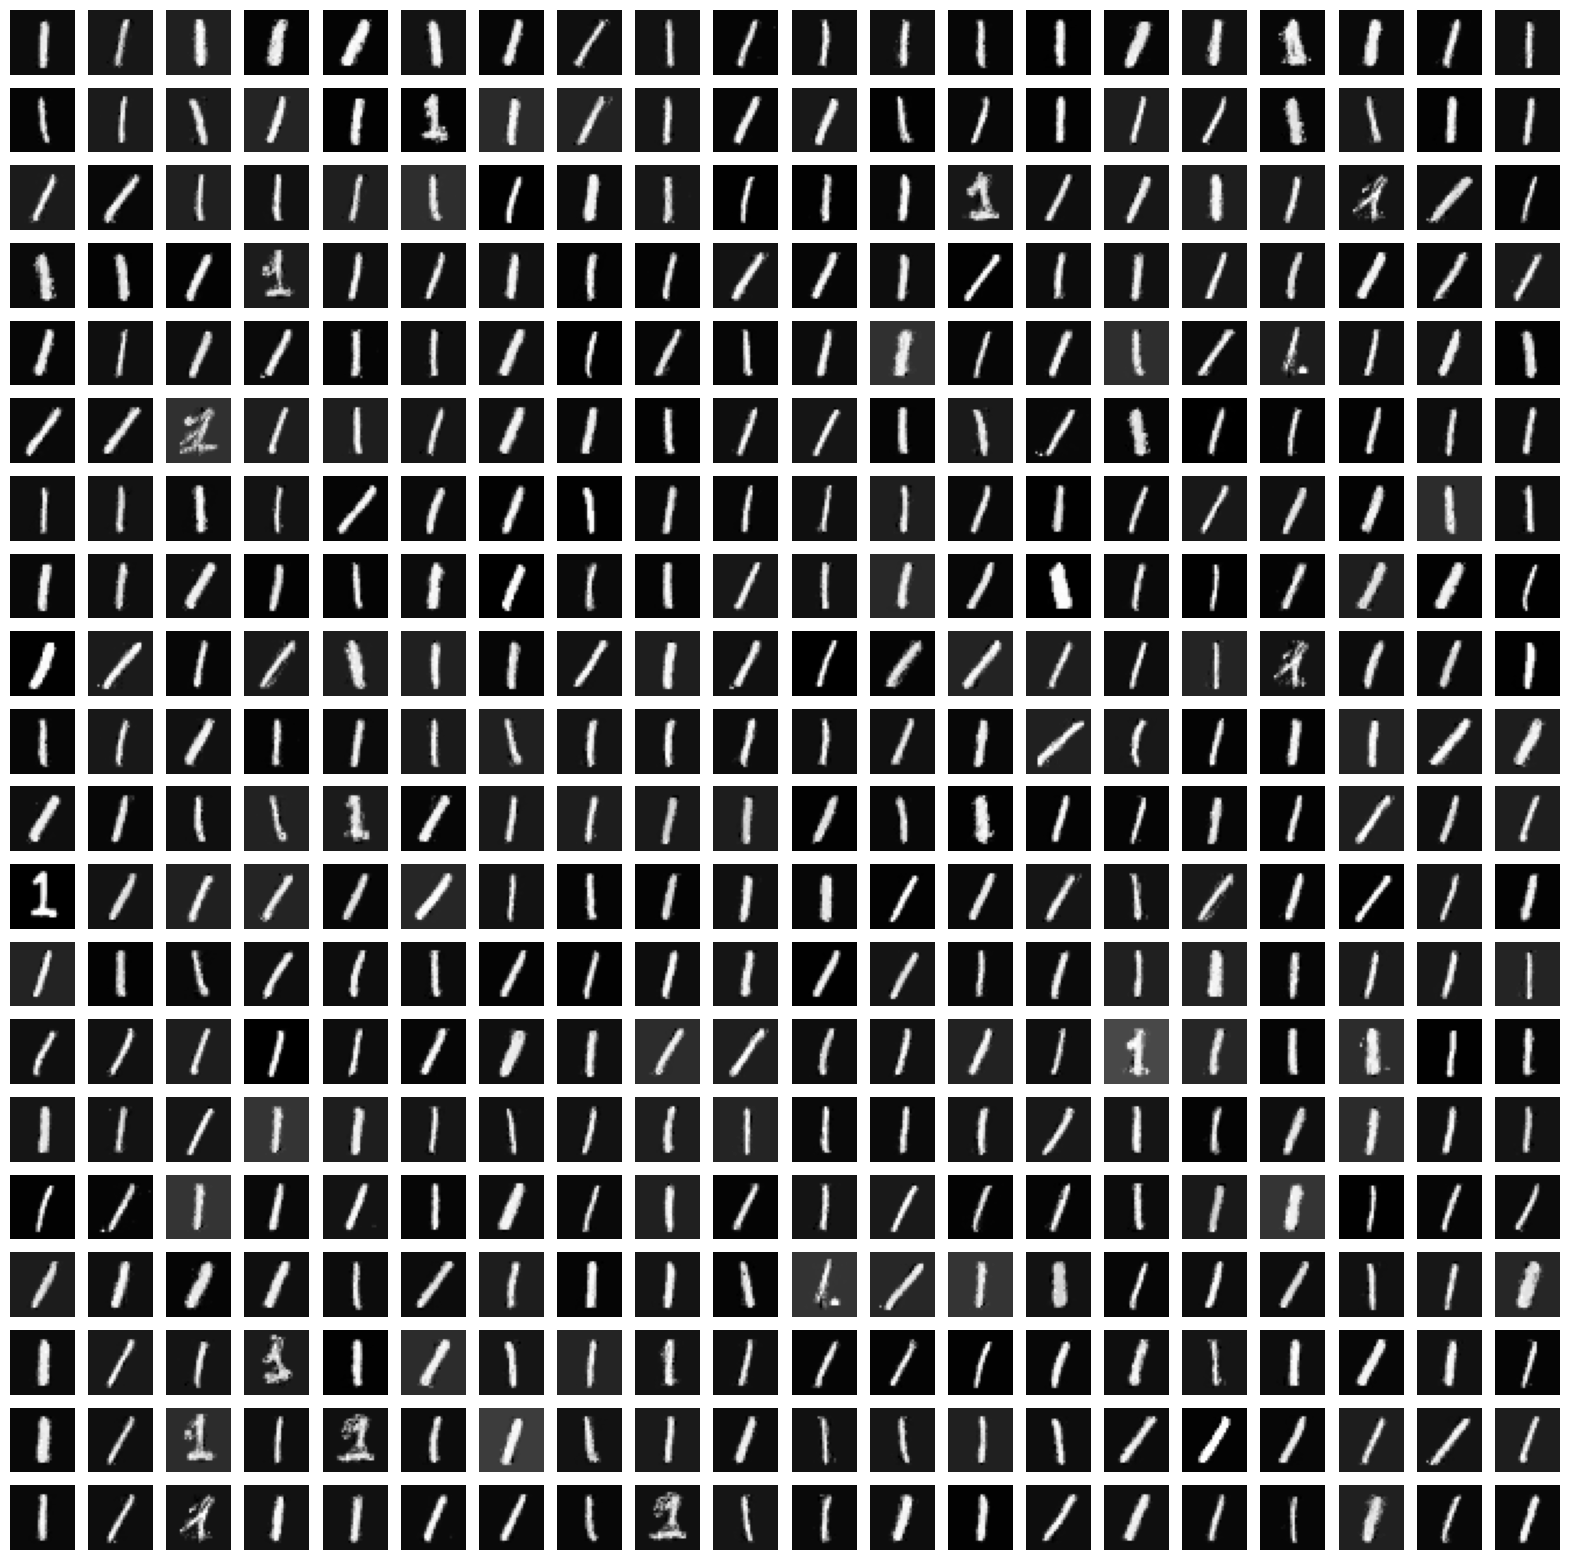

In [ ]:
plot_generated_images(generated_images)